### MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.

This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
    
URL: https://grouplens.org/datasets/movielens/100k/
Date of download: 23 Feb 2019

In [136]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


### Lets import all the datasets

#### Dataset info

This dataset contains information about 1682 movies (items), 943 users and 100,000 ratings. 
The movies are categorized into 18 genres as shown in the u_genre dataframe.



In [137]:
#Dataset info
u_info = pd.read_csv('ml-100k/u.info') #, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
u_info


,943 users
0,1682 items
1,100000 ratings


In [138]:
#List of genres
u_genre = pd.read_csv('ml-100k/u.genre',sep='|')
u_genre.drop(labels='0',axis=1,inplace=True)
u_genre.rename(index=str, columns={"unknown": "genre"},inplace=True)
u_genre

,genre
0,Action
1,Adventure
2,Animation
3,Children's
4,Comedy
5,Crime
6,Documentary
7,Drama
8,Fantasy
9,Film-Noir


The items dataframe contains detailed binary repreentation of the genres of each item in the dataset . We will be using this information to understand user preferences based on their ratings for each movie. 
The datafram also contains other columns like movie name, IMDB url, release date etc, which we won't need as yet.

In [139]:
#Information about movies (u.item)
## the last 19 fields are genres of type boolean; movies can be of multiple genres
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')
print(items.shape)
items.set_index('movie id', inplace=True)
items.head()

(1682, 24)


,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


We can get a better sense of the distribution of the movies in various genres by plotting a histogram for all genres. 

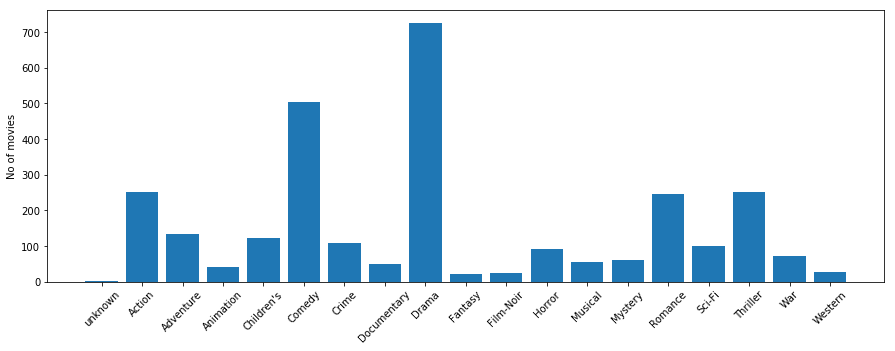

unknown          2
Action         251
Adventure      135
Animation       42
Children's     122
Comedy         505
Crime          109
Documentary     50
Drama          725
Fantasy         22
Film-Noir       24
Horror          92
Musical         56
Mystery         61
Romance        247
Sci-Fi         101
Thriller       251
War             71
Western         27
dtype: int64


In [140]:
plt.figure(figsize=(15,5))
column_sum=items.drop(labels=['movie title','release date','video release date','IMDb URL'],axis=1).sum(axis=0)
bins=(np.array(column_sum.keys()))
ypos=np.arange(len(bins))
plt.bar(ypos,column_sum.values,align='center', alpha=1)
plt.xticks(ypos, bins,rotation=45)
plt.ylabel('No of movies')
plt.show()
print(column_sum)

So while most of the genres are well represented, the drama and comedy genres most popular genres. We also have a small numer of movies that are unknown, which we will later remove since they do not help us in the recomendation system. 

The following dataframe, users contains general information about the users, like age, gender, occupation and zip code.

In [141]:
##Information about ratings (u.user)
users = pd.read_csv('ml-100k/u.user', sep='|', names=['user id','age', 'gender', 'occupation','zip code'],encoding='latin-1')
print(users.shape)
users.set_index('user id',inplace=True)
users.head()


(943, 5)


,age,gender,occupation,zip code
user id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


We will be focussing on user 1 for the first part of this exercise, which is building a content-based recommendation. So, for context, this user is 24 years old, Male and works as a technician.



The ratings data is the other important dataframe in the dataset apart from items, and contains the rating on a scale of 1-5 given by each user for all the movies they have watched.

In [142]:
##Information about ratings (u.data)
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id','movie id', 'rating', 'timestamp'],encoding='latin-1')
ratings.drop(labels='timestamp',axis=1,inplace=True)
print(ratings.shape)
ratings.head()

(100000, 3)


,user_id,movie id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Lets see the activity rate of each user in this dataframe by grouping by user_id 

   user_id  movie id  rating
0        1       272     272
1        2        62      62
2        3        54      54
3        4        24      24
4        5       175     175


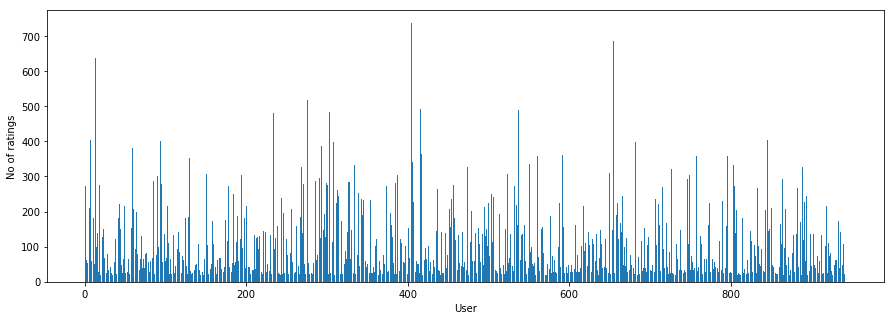

In [143]:
user_groups=ratings.groupby(by='user_id').count()
user_groups.reset_index(level=0, inplace=True)
print(user_groups.head())

plt.figure(figsize=(15,5))
plt.bar(user_groups['user_id'],user_groups['rating'])
plt.ylabel('No of ratings')
plt.xlabel('User')

In [144]:
user_groups.sort_values(by='rating',ascending=False).head()

,user_id,movie id,rating
404,405,737,737
654,655,685,685
12,13,636,636
449,450,540,540
275,276,518,518


### Lets try building a content based filter for user with user id 1

In [145]:
item_features=items.drop(labels=['movie title','release date','video release date','IMDb URL','unknown'],axis=1)
item_features.head(6)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


#### Cleaning the data
We will check to see of all the movies are assigned to a genre. If not, we have to remove them

In [146]:
#calculate sum of all rows and normalize each cateogy for each item
row_sum=item_features.sum(axis=1)
row_sum[row_sum==0]

movie id
267     0
1373    0
dtype: int64

In [147]:
item_features.drop(item_features.index[266],inplace=True)
item_features.drop(item_features.index[1371],inplace=True)

In [148]:
print('No of movies with id 267 or 1327 =',len(ratings[(ratings['movie id']==267)|(ratings['movie id']==1327)]))
ratings=ratings[(ratings['movie id']!=267)&(ratings['movie id']!=1327)]
print(len(ratings))


No of movies with id 267 or 1327 = 12
99988


In [149]:
#now we have deleted the two movies
row_sum=item_features.sum(axis=1)
row_sum[row_sum==0]

Series([], dtype: int64)

#### Lets normalize the item data

In [150]:
#now we can normalize the features for each item(movie)
print(' 1st row before normalization: \n',item_features.iloc[1])
item_features=item_features.divide(np.sqrt(np.array(row_sum)),axis=0)
print('\n  1st row after normalization: \n',item_features.iloc[1])

 1st row before normalization: 
 Action         1
Adventure      1
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       1
War            0
Western        0
Name: 2, dtype: int64

  1st row after normalization: 
 Action         0.57735
Adventure      0.57735
Animation      0.00000
Children's     0.00000
Comedy         0.00000
Crime          0.00000
Documentary    0.00000
Drama          0.00000
Fantasy        0.00000
Film-Noir      0.00000
Horror         0.00000
Musical        0.00000
Mystery        0.00000
Romance        0.00000
Sci-Fi         0.00000
Thriller       0.57735
War            0.00000
Western        0.00000
Name: 2, dtype: float64


In [151]:
item_features[:1].sum(axis=0)

Action         0.00000
Adventure      0.00000
Animation      0.57735
Children's     0.57735
Comedy         0.57735
Crime          0.00000
Documentary    0.00000
Drama          0.00000
Fantasy        0.00000
Film-Noir      0.00000
Horror         0.00000
Musical        0.00000
Mystery        0.00000
Romance        0.00000
Sci-Fi         0.00000
Thriller       0.00000
War            0.00000
Western        0.00000
dtype: float64

In [152]:
#calculate DF and IDF for each feature for the items

#DF is number of movies in each genre OR frequency of each genre in all collection of movies. 
#we calculate this by taking the sum along the columns
column_sum=item_features.sum(axis=0)
print(column_sum)

#IDF is estimates as inverse log of DF
IDF=list(np.log10(len(item_features)/column_sum))
IDF

Action         165.249801
Adventure       82.710900
Animation       25.834202
Children's      78.376845
Comedy         406.028833
Crime           73.748145
Documentary     48.535534
Drama          608.499823
Fantasy         12.567362
Film-Noir       16.007707
Horror          75.002074
Musical         36.003700
Mystery         39.042132
Romance        171.160582
Sci-Fi          62.770545
Thriller       172.661332
War             46.299560
Western         21.524580
dtype: float64


[1.0071683369822377,
 1.3077465335794851,
 1.8131142320928169,
 1.3311215018906666,
 0.61675240650110252,
 1.3575581788131872,
 1.5392494703653903,
 0.44104882528538536,
 2.1260651621287252,
 2.0209801495005748,
 1.3502360117032757,
 1.6689621505752525,
 1.6337757563061734,
 0.99190552690509259,
 1.4275533806581762,
 0.988114193954023,
 1.5597324205954604,
 1.8923746048524144]

From the above caculations, we observe that the DF for drama and comedy are the highest as also previously observed in the bar plot. The IDF values are invesely related to DF, so drama and comedy will show the lowest IDF values. This allows us to counter the bias in recommendations, without which the genre 'Drama' or 'Comedy' would be assigned higher weights just because of their high frequency in the dataset.   

#### The dot product of movie feature vectors and IDF vectors gives us the weighted scores of each movie.

As seen below in the case of movie id 1, Animation, Children's and Comedy have decreasing weighted scores. This is becasue there are only 42 Animation movies compared to 122 and 505 Children's and Comedy movies respectively. Hence, the Animation genre gets a higher rating. 

In [153]:
#lets calculate weighted score of features for each item by taking dot product of feature vector for each item with the IDF vector
item_features=item_features.multiply(IDF,axis=1)
item_features.iloc[0]

Action         0.000000
Adventure      0.000000
Animation      1.046802
Children's     0.768523
Comedy         0.356082
Crime          0.000000
Documentary    0.000000
Drama          0.000000
Fantasy        0.000000
Film-Noir      0.000000
Horror         0.000000
Musical        0.000000
Mystery        0.000000
Romance        0.000000
Sci-Fi         0.000000
Thriller       0.000000
War            0.000000
Western        0.000000
Name: 1, dtype: float64

### Find movies similar to a given movies
#### we can use the weighted scores for each movie to find similarities with other movies 
We can do this by computing dot product between the weighted scores for each movie pair.


In [163]:
movie_liked='Batman'

#find movies called Toy Story in items dataframe
movie_id_liked=(items[items['movie title'].str.contains(movie_liked)].index.values)
print(movie_id_liked)
target_features=item_features.loc[movie_id_liked[0]]
target_features

[ 29 231 254 403]


Action         0.503584
Adventure      0.653873
Animation      0.000000
Children's     0.000000
Comedy         0.308376
Crime          0.678779
Documentary    0.000000
Drama          0.000000
Fantasy        0.000000
Film-Noir      0.000000
Horror         0.000000
Musical        0.000000
Mystery        0.000000
Romance        0.000000
Sci-Fi         0.000000
Thriller       0.000000
War            0.000000
Western        0.000000
Name: 29, dtype: float64

In [165]:
target_features=target_features.reshape(1, -1)
cosine_sim=cosine_similarity(item_features,target_features)
print(cosine_sim)

[[ 0.07332028]
 [ 0.63669555]
 [ 0.        ]
 ..., 
 [ 0.        ]
 [ 0.27726738]
 [ 0.        ]]


C:\Users\Sangy\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


In [168]:
cosine_sim=cosine_sim.flatten()
cosine_sim
results_df=pd.DataFrame(cosine_sim,list(item_features.index.values))

suggested=results_df.sort_values(by=0,ascending=False).head().index.values
[print(items.loc[i]['movie title']) for i in suggested]

Batman Forever (1995)
Batman Returns (1992)
Cliffhanger (1993)
Rumble in the Bronx (1995)
Batman & Robin (1997)


[None, None, None, None, None]